# How To Run Our Models Step By Step


In [128]:
%load_ext autoreload
%autoreload 2

#Imports Neccessary
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.datasets import IMDB
from torchtext.transforms import ToTensor
from torchtext.vocab import build_vocab_from_iterator
#Pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
import time

#MOdel Architectures
from NNDL.transformer.architecture import TransformerModel,TransformerMetaModel
from NNDL.RNN.architecture import RNN,MyNetwork
from NNDL.TestModel.structure import FCNN
import NNDL.Utils.solver as solver
from NNDL.Utils.weight_tracker import ActivationMonitor
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from transformers import AutoTokenizer
import functools
import tensorflow as tf

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Pick Your Universal Hyperparamaters:

In [129]:
#For all Models
batch_size = 2
epochs = 3
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

#For all text models
input_dim = 100
hidden_dim = 50
output_dim = 10

#For CNN
n_filters=30
filter_size=5
drop_frac=0.5

#For Embedding Layers
embed_dim = 50

#Dataset Portions for the Base Models
train_size = 0.2
test_size = 0.1
#Dataset Portion for the Meta model(Taken out of data not used by base models)
meta_train_size = 0.2
meta_test_size = 0.1

torch.cuda.amp.autocast()
device = "cpu" # Run on CPU for your own work: some parts of the ensemble model do no have GPU support
print(f"==>> torch.cuda.is_available(): {torch.cuda.is_available()}")
print(device)


==>> torch.cuda.is_available(): True
cpu


# Setup Of Dataset/Data Loaders Here




In [130]:
#Custom Dataloader Class that parses the CSV into a format usable by Text
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from transformers import BertTokenizer
from PIL import Image
import requests
from torchvision.io import read_image
import torchvision.transforms as transforms

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Input text
text = "Hello, how are you doing?"

vec = GloVe(name='6B', dim=embed_dim)
class FullDataset(Dataset):
    def __init__(self, data, root_dir):
        self.root_dir = root_dir
        self.data = data
        self.mapping = {'arts, crafts & sewing': 0,'books': 1, 'clothing, shoes & jewelry': 2,'electronics': 3, 'grocery & gourmet food': 4,'health & personal care': 5, 'musical instruments': 6, 'patio, lawn & garden': 7,'sports & outdoors': 8, 'toys & games': 9}
        self.cur_map = 0
        self.print_data=False
        self.process_images=True
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        if  type(self.data.iloc[index, 0]) == float:
            t="N/A"     
            print('N/A Example  In dataset')
        else:
            t=self.data.iloc[index, 0]
        tokens = tokenizer.tokenize(t)
        token_length=input_dim
        tokens=tokens+[""] * (token_length-len(tokens))  if len(tokens)<token_length else tokens[:token_length]
        tokens_emb = [vec.stoi.get(token, 0) for token in tokens]
        img_link = os.path.join(self.data.iloc[index, 1])
        category_text = os.path.join(self.data.iloc[index, 2])
        if category_text in self.mapping:
            category = self.mapping[category_text]
        else:
            print(category_text)
            self.mapping[category_text] = self.cur_map
            print("HOUSTON WE GOT A PROBLEM")
            print(self.mapping)
            category = self.cur_map
            self.cur_map+=1
        if self.process_images==False:
            if self.print_data==True:
                print(f"img_link:{img_link}")
                print(f"Name+Desciption{t}")
            return torch.tensor(tokens_emb),0,category
        try:
            image_or = Image.open(requests.get(img_link, stream=True).raw) 
        except:
            print(img_link)
        image= image_or.resize((64,64))
        transform = transforms.Compose([transforms.PILToTensor()])
        torch_image = transform(image)
        if torch_image.shape[0] != 3:
            print(img_link)
            print("WTF")
            print(torch_image.shape)
            x=torch.zeros_like(torch_image)
            torch_image=torch.cat([torch_image,x,x],dim=0)
            print(f"Post correction shape:{torch_image.shape}")
        if self.print_data==True:
            print("Sanity Check the model's classification here!")
            print("Given The following image, name and description, what is the category?")
            display(image_or)
            print(f"Name and Desciption: {t}")
            print(f"Here are the possible categories: 'arts, crafts & sewing','books', 'clothing, shoes & jewelry','electronics', 'grocery & gourmet food','health & personal care', 'musical instruments', 'patio, lawn & garden','sports & outdoors','toys & games'")
        return torch.tensor(tokens_emb),torch_image,category


In [131]:
#For Transformer,CNN,RNN
d = pd.read_csv(r'data/test_remove_filtered.csv') #Place You Path to the CSV file  here

full_dataset = FullDataset(data=d,root_dir='/')

train,test,meta = torch.utils.data.random_split(full_dataset,[train_size,test_size,1-(train_size+test_size)])
train_dataloader =  DataLoader(train, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
test_dataloader =  DataLoader(test, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
meta_train,meta_test,sanity = torch.utils.data.random_split(meta,[meta_train_size,meta_test_size,1-(meta_train_size+meta_test_size)])
meta_train_dataloader = DataLoader(meta_train, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
meta_test_dataloader = DataLoader(meta_test, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)
sanity_dataloader = DataLoader(sanity, batch_size=1, shuffle=True, num_workers=0, drop_last=True)

# FOR THE BASE MODELS

## Declare The Base Model Architectures

1. Create your model architecture in your folder
2. Pick your loss function and optimizer

In [132]:

model = TransformerModel(input_dim,embed_dim,output_dim).to(device)
#model2 = MyNetwork(embed_dim,n_filters,filter_size,drop_frac,output_dim,embed_dim).to(device)
#model3= RNN(input_dim,hidden_dim,output_dim,embed_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
base_optimizer1 = torch.optim.Adam(model.parameters(),lr=1e-4)
#base_optimizer2 = torch.optim.Adam(model2.parameters(),lr=1e-3)
#base_optimizer3 = torch.optim.Adam(model3.parameters(),lr=1e-3)



## Either Load In an Existing Base Model Using this Format:

In [133]:
state_dict = torch.load(f"models\TransformerModel\9432-4715_epochs-0.pt")# the path should be the path to the saved checkpoints
model.load_state_dict(state_dict)
model.to(device)
solver.test(test_dataloader,model,loss_fn)

Progress: 1/2357,accuracy:0.0,test_loss:0.206586
Progress: 2/2357,accuracy:0.0,test_loss:2.387501
Progress: 3/2357,accuracy:0.1,test_loss:1.758094
Progress: 4/2357,accuracy:0.1,test_loss:1.394487
Progress: 5/2357,accuracy:0.2,test_loss:1.130516
Progress: 6/2357,accuracy:0.2,test_loss:0.964584
Progress: 7/2357,accuracy:0.2,test_loss:1.158363
Progress: 8/2357,accuracy:0.2,test_loss:1.138149
http://ecx.images-amazon.com/images/I/41ln92BEGVL._SY445_.jpg


UnboundLocalError: local variable 'image_or' referenced before assignment

## OR Train a Model Using this format:

In [ ]:
train_dataloader.dataset.dataset.process_images=False
test_dataloader.dataset.dataset.process_images=False
for t in range(epochs):
    #with torch.autograd.detect_anomaly():
        print(f"Epoch {t+1}\n-------------------------------")
        solver.train(train_dataloader, model, loss_fn, base_optimizer1)
        torch.save(model.state_dict(), f"models\{type(model).__name__}\{len(train)}-{len(test)}_epochs-{t}.pt")
        torch.cuda.empty_cache()
        solver.test(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.567462  [    2/ 9432]
loss: 0.139618  [  258/ 9432]


KeyboardInterrupt: 

# FOR THE META MODEL:

## Load In all The Neccessary Base ModelS

### Some Tensorflow Specific Integrations for the image model(which is in tensorflow)

In [ ]:

top3_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'
top2_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'
custom_objects = {'top3_acc':top3_acc, 'top2_acc':top2_acc}
#Use Tensorflow Model
t_model = tf.keras.models.load_model("models\image\gln_model_Qc0Yq7.keras",custom_objects=custom_objects)
t_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


OSError: No file or directory found at models\image\gln_model_Qc0Yq7.keras

## Declare and Prepare all your models for one of the ensemble methods

In [ ]:

model1 = TransformerModel(input_dim,embed_dim,output_dim).to(device)
model2 = MyNetwork(embed_dim,n_filters,filter_size,drop_frac,output_dim,embed_dim).to(device)
model3= RNN(input_dim,hidden_dim,output_dim,embed_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
state_dict = torch.load(f"models\TransformerModel/0.25-0.05_epochs-0.pt")
model1.load_state_dict(state_dict)
state_dict = torch.load(f"models\MyNetwork/0.25-0.05_epochs-0.pt")
model2.load_state_dict(state_dict)

model_list= [model1,model2]# You need to place every text model into this list
weights = [0.5,0.25,0.25] # You need to place a weightage to be given for every model's output(last index is the image model)


### EITHER Use Naive Averaging of Outputs as the Ensemble Method 

Beginnning inference
Testing Prediction
Progress: 1/147,accuracy:0.6,test_loss:1.027522
Testing Prediction
Progress: 2/147,accuracy:1.1,test_loss:1.078115
Testing Prediction
Progress: 3/147,accuracy:1.6,test_loss:1.073324
Testing Prediction
Progress: 4/147,accuracy:2.2,test_loss:1.032815
Testing Prediction
Progress: 5/147,accuracy:2.8,test_loss:1.032463
Testing Prediction
Progress: 6/147,accuracy:3.3,test_loss:1.021586
Testing Prediction
Progress: 7/147,accuracy:3.9,test_loss:1.031004
Testing Prediction
Progress: 8/147,accuracy:4.3,test_loss:1.052914
Testing Prediction
Progress: 9/147,accuracy:4.8,test_loss:1.056593
Testing Prediction
Progress: 10/147,accuracy:5.4,test_loss:1.053956
Testing Prediction
Progress: 11/147,accuracy:5.9,test_loss:1.060998
Testing Prediction
Progress: 12/147,accuracy:6.5,test_loss:1.044339
Testing Prediction
Progress: 13/147,accuracy:7.0,test_loss:1.056038
Testing Prediction
Progress: 14/147,accuracy:7.6,test_loss:1.050667
Testing Prediction
Progress: 15/147,

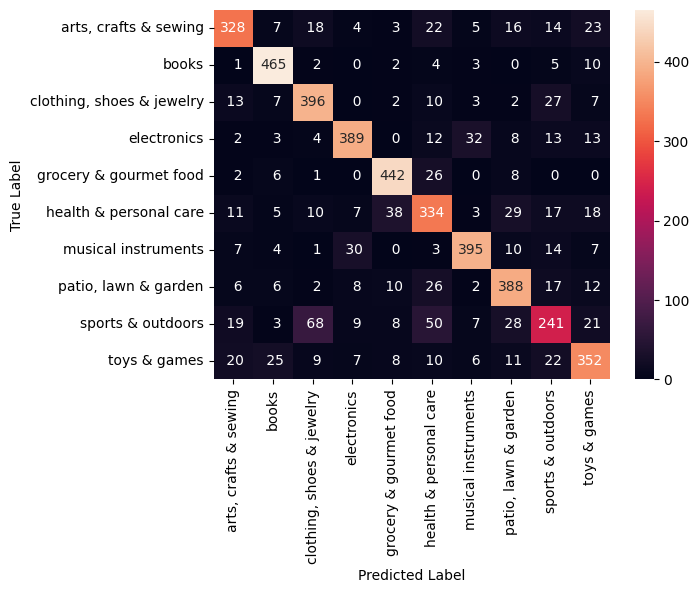

Test Error: 
 Accuracy: 79.1%, Avg loss: 1.056892 



In [ ]:
weights = [0.33,0.33,0.33]

solver.test_ensemble(test_dataloader, model_list, loss_fn,t_model,weights)

## OR use weighted Averaging of outputs as the ensemble model

In [ ]:
weights = [0.33,0.33,0.33] # Choose custom weights here: idx correspondss to model number, last idx is the image model

solver.test_ensemble(test_dataloader, model_list, loss_fn,t_model,weights)

Beginnning inference
Testing Prediction
Progress: 1/147,accuracy:0.6,test_loss:0.950619
Testing Prediction
Progress: 2/147,accuracy:1.1,test_loss:1.040287
Testing Prediction
Progress: 3/147,accuracy:1.6,test_loss:1.089526
Testing Prediction
Progress: 4/147,accuracy:2.1,test_loss:1.064426
Testing Prediction
Progress: 5/147,accuracy:2.7,test_loss:1.069670
http://ecx.images-amazon.com/images/I/41TFDybTf6L._SY300_.jpg


UnboundLocalError: local variable 'image' referenced before assignment

## OR Train A Meta Model On the Predictions of your base models:

In [ ]:
#Declare your Meta Model Architecture

#meta_model = FCNN(output_dim*(len(model_list)+1),hidden_dim*(len(model_list)+1),output_dim).to(device)
meta_model=TransformerMetaModel(len(model_list)+1,output_dim,output_dim)
optimizer = torch.optim.Adam(meta_model.parameters(),lr=1e-3)

# This is the training portion
for t in range(epochs):
    #with torch.autograd.detect_anomaly():
        print(f"Epoch {t+1}\n-------------------------------")
        solver.train_stack(meta_train_dataloader,model_list,loss_fn,optimizer,meta_model,t_model)
        torch.save(meta_model.state_dict(), f"models\{type(meta_model).__name__}\{meta_train_size}-{meta_test_size}_epochs-{t}.pt") # this will save your model weights to a directory with the name of the model architecture name
        torch.cuda.empty_cache()
        solver.test_stack(meta_train_dataloader,model_list,loss_fn,meta_model,t_model)
        


Epoch 1
-------------------------------
Training Meta Model
loss: 2.591773  [   32/ 6602]
loss: 2.591773  [   32/ 6602]
loss: 2.789546  [   64/ 6602]
loss: 2.538496  [   96/ 6602]
loss: 2.510524  [  128/ 6602]
loss: 2.350821  [  160/ 6602]
loss: 2.302735  [  192/ 6602]
loss: 2.495427  [  224/ 6602]
loss: 2.342085  [  256/ 6602]
loss: 2.245266  [  288/ 6602]
loss: 2.095569  [  320/ 6602]
loss: 2.392676  [  352/ 6602]
loss: 2.211416  [  384/ 6602]
loss: 2.027610  [  416/ 6602]
loss: 2.258869  [  448/ 6602]
loss: 2.292414  [  480/ 6602]
loss: 2.146991  [  512/ 6602]
loss: 2.169219  [  544/ 6602]
loss: 2.065369  [  576/ 6602]
loss: 2.037255  [  608/ 6602]
loss: 1.923294  [  640/ 6602]
loss: 2.024649  [  672/ 6602]
loss: 1.968048  [  704/ 6602]
loss: 1.983702  [  736/ 6602]
loss: 2.086825  [  768/ 6602]
loss: 2.028045  [  800/ 6602]
loss: 1.886442  [  832/ 6602]
loss: 1.896928  [  864/ 6602]
loss: 1.985428  [  896/ 6602]
loss: 2.151915  [  928/ 6602]
loss: 1.987231  [  960/ 6602]
loss: 1.88

UnboundLocalError: local variable 'image' referenced before assignment

# Sanity Check Your Models Here:


Sanity Check the model's classification here!
Given The following image, name and description, what is the category?


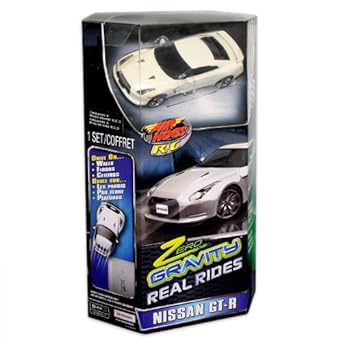

Name and Desciption: air hogs nano zero gravity real rides - white nissan gtr nano sized zero gravity vehicle!  the ultimate in indoor rc racing!  a fully functional rc car that drives on the floor, up the walls and even upside-down!  outstanding scale speed performance on any smooth surface.  the ultimate fully functional rc vehicle!  drives on your floor, ceiling and walls! micro siezed for best play action.  now nano sized at a ratio of 1 to 64 compared to the regular zero gravity.
Here are the possible categories: 'arts, crafts & sewing','books', 'clothing, shoes & jewelry': 2,'electronics': 3, 'grocery & gourmet food','health & personal care', 'musical instruments', 'patio, lawn & garden','sports & outdoors','toys & games'
The Meta Model Predicted:patio, lawn & garden, while the actual categpry on amazon is toys & games


In [134]:
#Sanity Check With Single Examples(currently not working)
sanity_dataloader.dataset.dataset.dataset.process_images=True
sanity_dataloader.dataset.dataset.dataset.print_data=True
model_list = [model]
weights = [1]
tmodel=None
with torch.no_grad():
    class_names=['arts, crafts & sewing','books', 'clothing, shoes & jewelry','electronics', 'grocery & gourmet food','health & personal care', 'musical instruments', 'patio, lawn & garden','sports & outdoors','toys & games']
    X_text,X_img, actual_label = next(iter(sanity_dataloader))
    actual_label = actual_label[0]
    #PRedicting USing Models
    X_img=torch.transpose(X_img,1,3)
    X_img = X_img.numpy()
    X_img = tf.convert_to_tensor(X_img)
    X_img=tf.cast(X_img,tf.float32)
    X_img=tf.keras.applications.inception_v3.preprocess_input(X_img)
    pred_by_model = []
    for model in model_list:
        out = model(X_text.to(device))
        pred_by_model.append(out)
    #t_out=t_model.predict(X_img)
    #t_out=torch.tensor(t_out)
    #pred_by_model.append(t_out)
    for it,weight in enumerate(weights):
        pred_by_model[it]*=weight
    stacked_tensor = torch.stack(pred_by_model)
    pred = torch.sum(stacked_tensor,axis=0)
    pred=np.argmax(np.array(pred), axis=1)
    print(f"The Meta Model Predicted:{class_names[pred[0]]}, while the actual categpry on amazon is {class_names[actual_label]}")